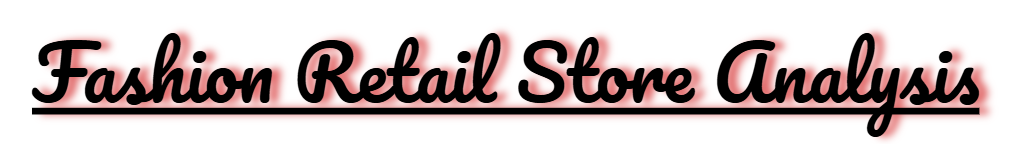

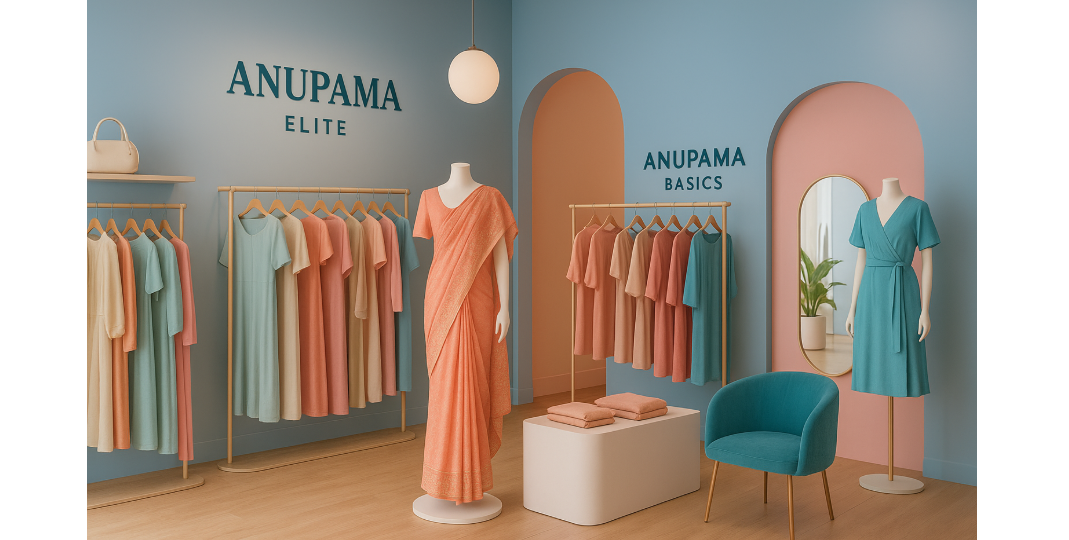

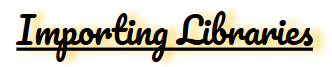

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso


In [19]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

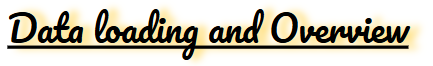

In [20]:
# Load the dataset
url = r"C:\Users\Shreya\Downloads\Fashion_Retail_Sales.csv"
df = pd.read_csv(url)

print("📊 DATASET OVERVIEW")
print("-" * 30)
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

print("\n📋 DATA TYPES")
print("-" * 20)
print(df.dtypes)

print("\n🔍 MISSING VALUES")
print("-" * 20)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_info[missing_info['Missing Count'] > 0])

print("\n📈 BASIC STATISTICS")
print("-" * 20)
print(df.describe())

📊 DATASET OVERVIEW
------------------------------
Dataset Shape: (3400, 6)
Columns: ['Customer Reference ID', 'Item Purchased', 'Purchase Amount (USD)', 'Date Purchase', 'Review Rating', 'Payment Method']

First 5 rows:
   Customer Reference ID Item Purchased  Purchase Amount (USD) Date Purchase  \
0                   4018        Handbag                 4619.0    05-02-2023   
1                   4115          Tunic                 2456.0    11-07-2023   
2                   4019       Tank Top                 2102.0    23-03-2023   
3                   4097       Leggings                 3126.0    15-03-2023   
4                   3997         Wallet                 3003.0    27-11-2022   

   Review Rating Payment Method  
0            NaN    Credit Card  
1            2.0    Credit Card  
2            4.1           Cash  
3            3.2           Cash  
4            4.7           Cash  

📋 DATA TYPES
--------------------
Customer Reference ID      int64
Item Purchased            o

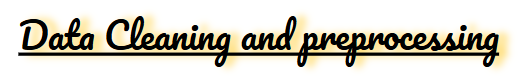

In [21]:
print("\n🧹 DATA CLEANING")
print("-" * 20)

# Convert date column to datetime
df['Date Purchase'] = pd.to_datetime(df['Date Purchase'], format='%d-%m-%Y')

# Handle missing values in Review Rating
df['Review Rating'] = df['Review Rating'].fillna(df['Review Rating'].median())

# Remove any duplicate rows
df_clean = df.drop_duplicates()
print(f"Removed {len(df) - len(df_clean)} duplicate rows")


🧹 DATA CLEANING
--------------------
Removed 0 duplicate rows


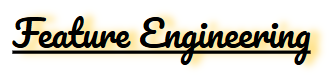

In [22]:
print("\n🛠️ FEATURE ENGINEERING")
print("-" * 25)

df_features = df_clean.copy()

# Temporal Features
df_features['Year'] = df_features['Date Purchase'].dt.year
df_features['Month'] = df_features['Date Purchase'].dt.month
df_features['Day'] = df_features['Date Purchase'].dt.day
df_features['Day_of_Week'] = df_features['Date Purchase'].dt.dayofweek
df_features['Week_of_Year'] = df_features['Date Purchase'].dt.isocalendar().week
df_features['Quarter'] = df_features['Date Purchase'].dt.quarter

# Season mapping
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_features['Season'] = df_features['Month'].apply(get_season)

# Price Categories
def categorize_price(amount):
    if amount < 2500:
        return 'Budget'
    elif amount < 3500:
        return 'Mid-range'
    elif amount < 4500:
        return 'Premium'
    else:
        return 'Luxury'

df_features['Price_Category'] = df_features['Purchase Amount (USD)'].apply(categorize_price)

# Review Rating Categories
def categorize_rating(rating):
    if pd.isna(rating):
        return 'No Rating'
    elif rating < 2:
        return 'Poor'
    elif rating < 3:
        return 'Average'
    elif rating < 4:
        return 'Good'
    else:
        return 'Excellent'

df_features['Rating_Category'] = df_features['Review Rating'].apply(categorize_rating)

# Customer Purchase Frequency
customer_freq = df_features['Customer Reference ID'].value_counts()
df_features['Customer_Purchase_Frequency'] = df_features['Customer Reference ID'].map(customer_freq)

# Customer Lifetime Value (sum of all purchases per customer)
customer_clv = df_features.groupby('Customer Reference ID')['Purchase Amount (USD)'].sum()
df_features['Customer_CLV'] = df_features['Customer Reference ID'].map(customer_clv)

# Item Category Mapping (simplified categorization)
clothing_items = ['T-shirt', 'Jeans', 'Trousers', 'Jacket', 'Tunic', 'Tank Top', 'Leggings', 
                  'Trench Coat', 'Pajamas', 'Romper', 'Onesie', 'Poncho']
accessories = ['Handbag', 'Wallet', 'Gloves', 'Bowtie']
footwear = ['Loafers', 'Slippers']

def categorize_item(item):
    if item in clothing_items:
        return 'Clothing'
    elif item in accessories:
        return 'Accessories'
    elif item in footwear:
        return 'Footwear'
    else:
        return 'Other'

df_features['Item_Category'] = df_features['Item Purchased'].apply(categorize_item)

# Days since first purchase (temporal trend)
min_date = df_features['Date Purchase'].min()
df_features['Days_Since_Start'] = (df_features['Date Purchase'] - min_date).dt.days

print("✅ Feature engineering completed!")
print(f"New shape: {df_features.shape}")
print(f"New features created: {df_features.shape[1] - df_clean.shape[1]}")


🛠️ FEATURE ENGINEERING
-------------------------
✅ Feature engineering completed!
New shape: (3400, 19)
New features created: 13


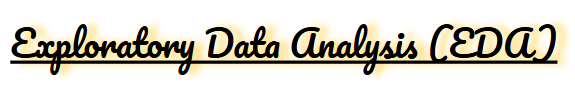


📊 EXPLORATORY DATA ANALYSIS
-----------------------------------


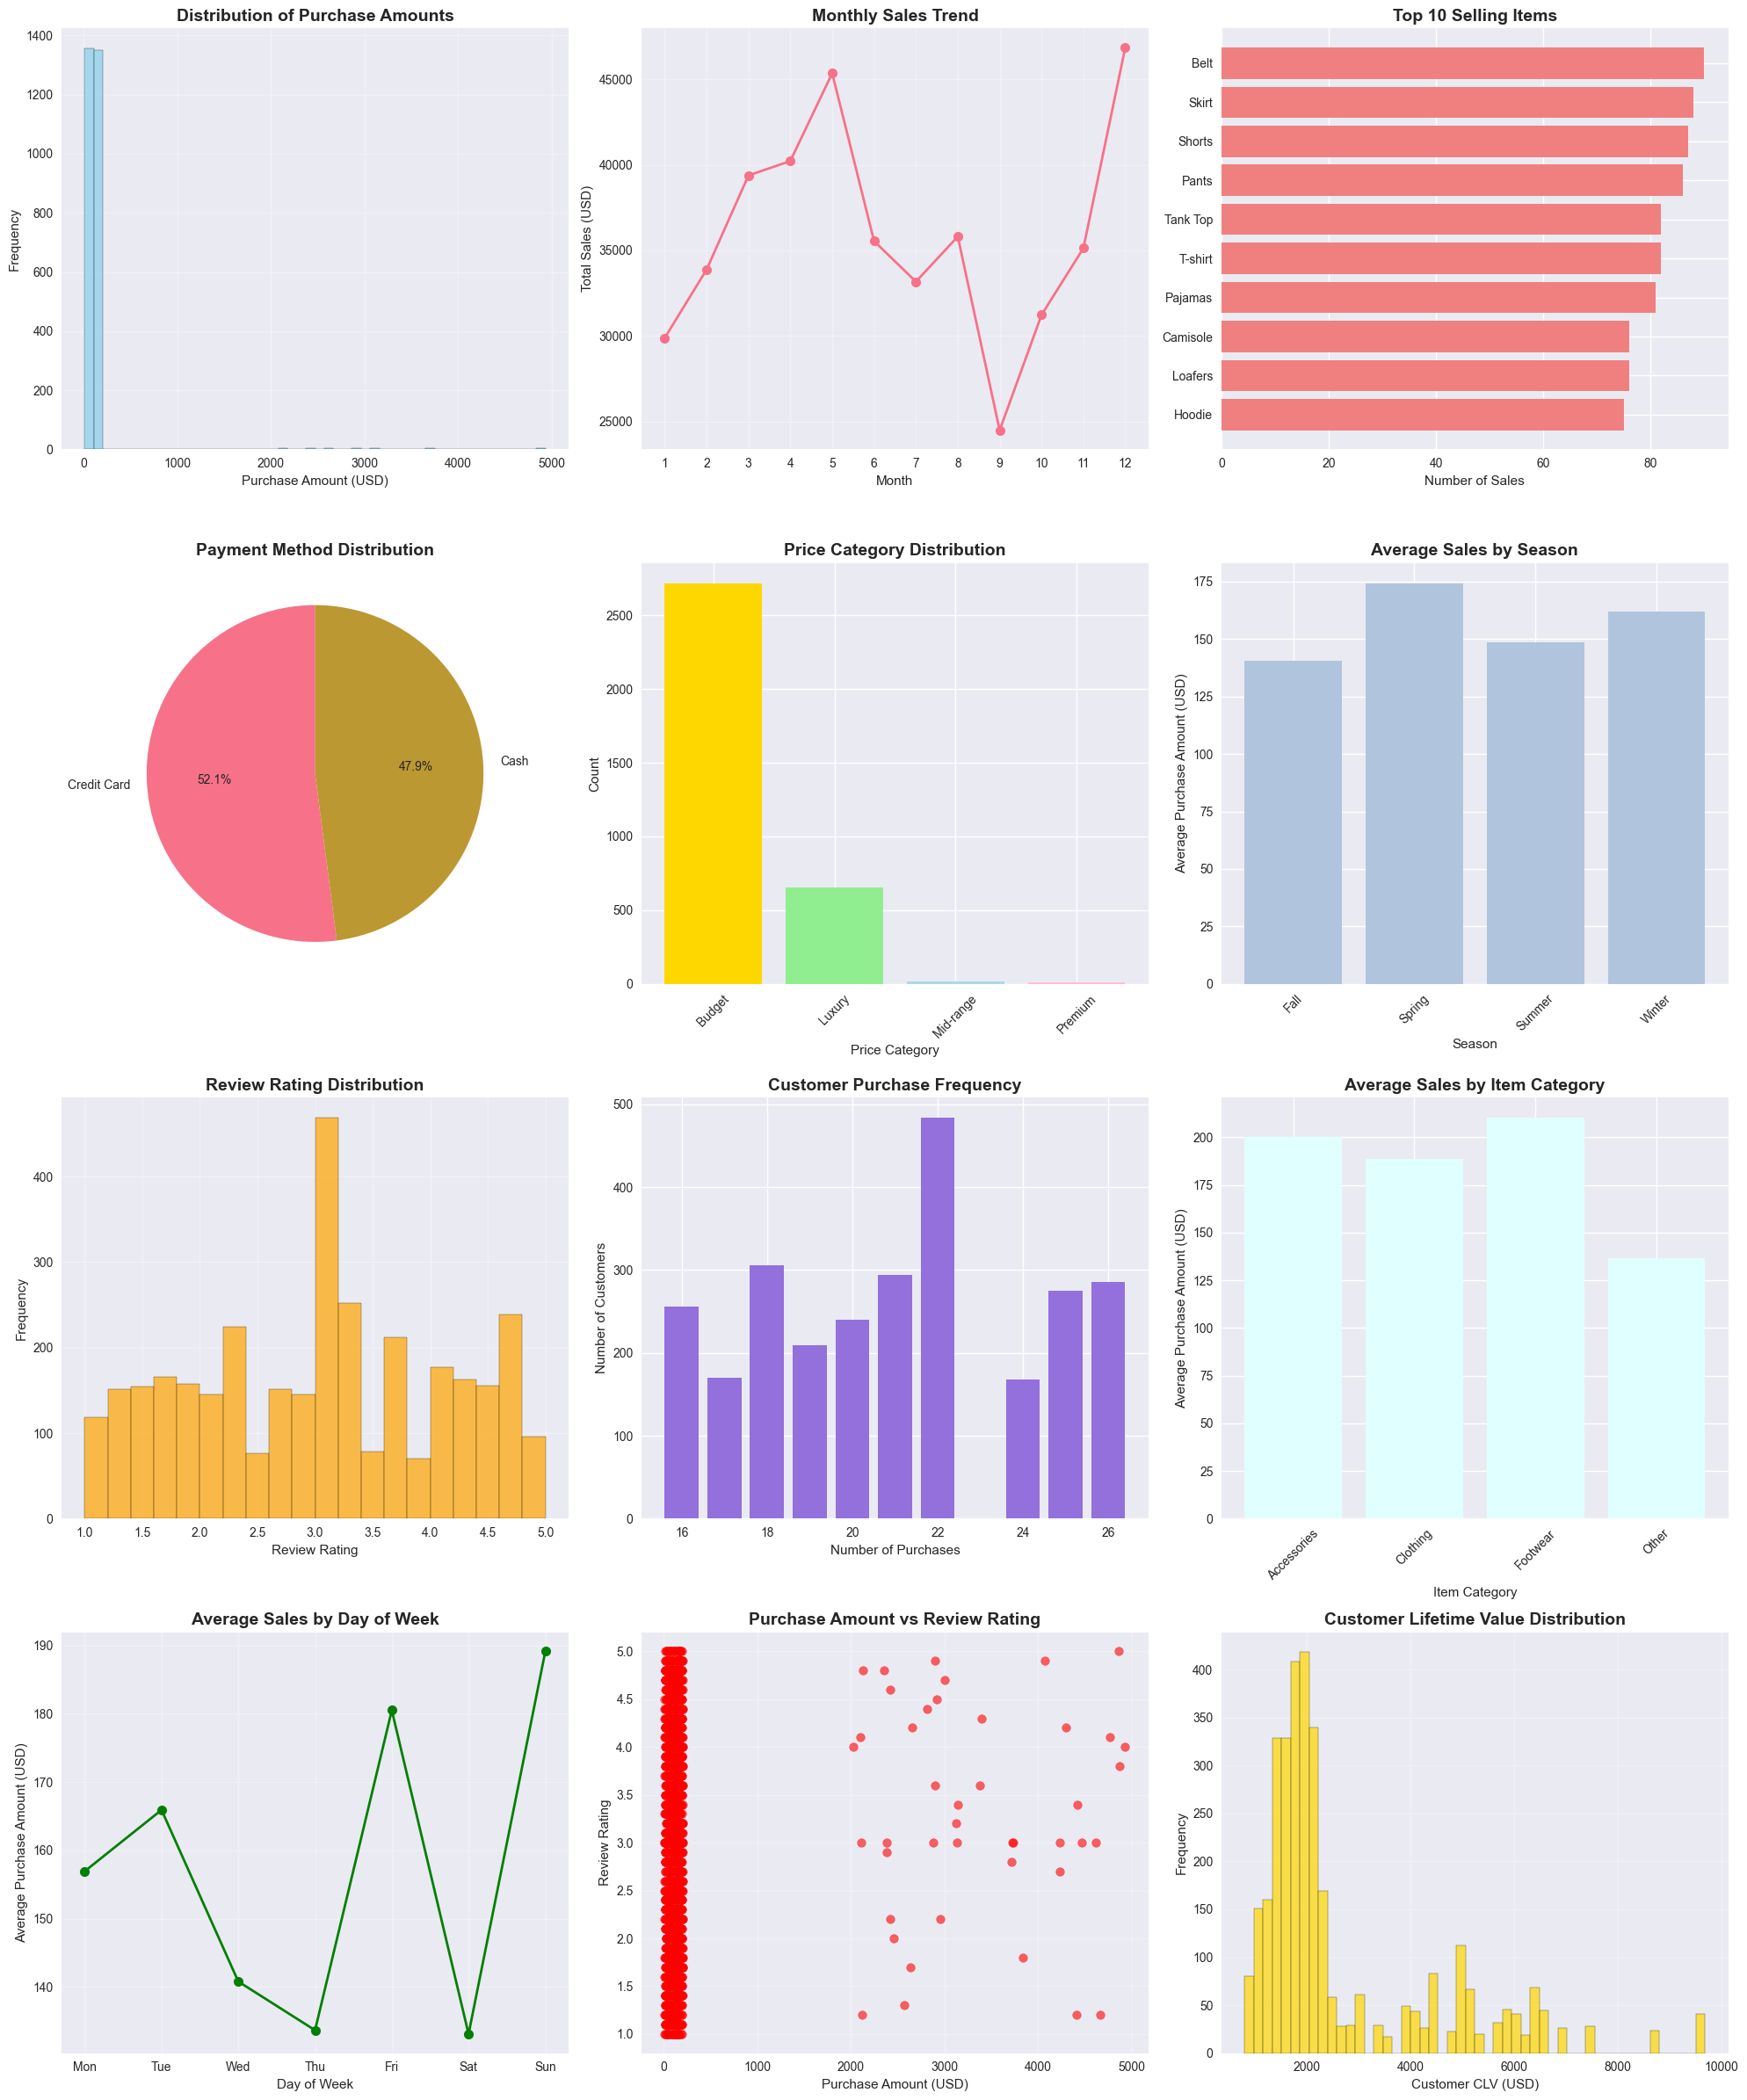


🔗 CORRELATION ANALYSIS
-------------------------


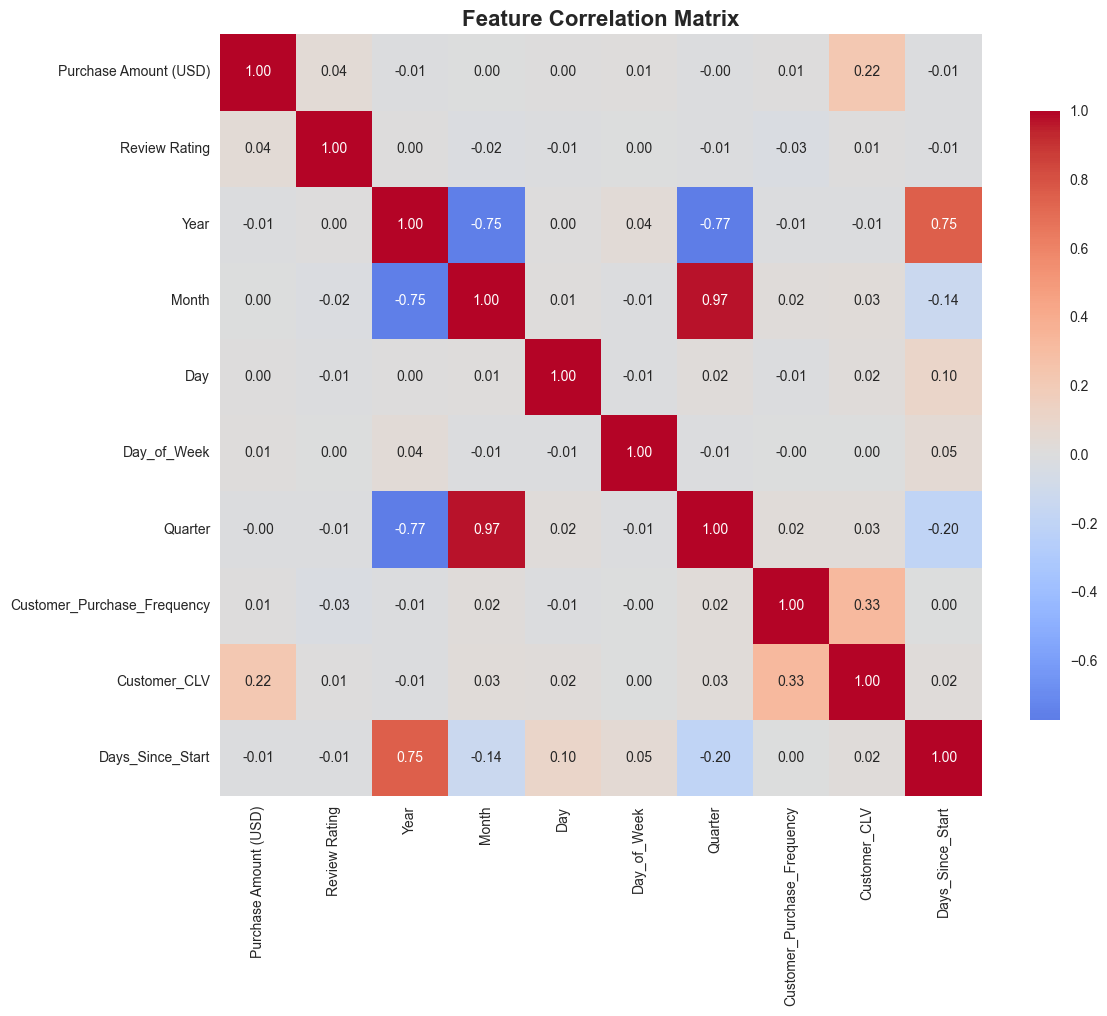

In [23]:
# =============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

print("\n📊 EXPLORATORY DATA ANALYSIS")
print("-" * 35)

# Create figure for multiple subplots
fig = plt.figure(figsize=(20, 24))

# 1. Purchase Amount Distribution
plt.subplot(4, 3, 1)
plt.hist(df_features['Purchase Amount (USD)'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Purchase Amounts', fontsize=14, fontweight='bold')
plt.xlabel('Purchase Amount (USD)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. Monthly Sales Trend
plt.subplot(4, 3, 2)
monthly_sales = df_features.groupby('Month')['Purchase Amount (USD)'].sum()
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2, markersize=8)
plt.title('Monthly Sales Trend', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Total Sales (USD)')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

# 3. Top Selling Items
plt.subplot(4, 3, 3)
top_items = df_features['Item Purchased'].value_counts().head(10)
plt.barh(range(len(top_items)), top_items.values, color='lightcoral')
plt.yticks(range(len(top_items)), top_items.index)
plt.title('Top 10 Selling Items', fontsize=14, fontweight='bold')
plt.xlabel('Number of Sales')
plt.gca().invert_yaxis()

# 4. Payment Method Distribution
plt.subplot(4, 3, 4)
payment_counts = df_features['Payment Method'].value_counts()
plt.pie(payment_counts.values, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Payment Method Distribution', fontsize=14, fontweight='bold')

# 5. Price Category Distribution
plt.subplot(4, 3, 5)
price_cat_counts = df_features['Price_Category'].value_counts()
colors = ['gold', 'lightgreen', 'lightblue', 'pink']
plt.bar(price_cat_counts.index, price_cat_counts.values, color=colors)
plt.title('Price Category Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 6. Seasonal Sales Pattern
plt.subplot(4, 3, 6)
seasonal_sales = df_features.groupby('Season')['Purchase Amount (USD)'].mean()
plt.bar(seasonal_sales.index, seasonal_sales.values, color='lightsteelblue')
plt.title('Average Sales by Season', fontsize=14, fontweight='bold')
plt.xlabel('Season')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(rotation=45)

# 7. Review Rating Distribution
plt.subplot(4, 3, 7)
plt.hist(df_features['Review Rating'].dropna(), bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Review Rating Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 8. Customer Purchase Frequency
plt.subplot(4, 3, 8)
freq_dist = df_features['Customer_Purchase_Frequency'].value_counts().head(10)
plt.bar(freq_dist.index, freq_dist.values, color='mediumpurple')
plt.title('Customer Purchase Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')

# 9. Item Category Performance
plt.subplot(4, 3, 9)
cat_sales = df_features.groupby('Item_Category')['Purchase Amount (USD)'].mean()
plt.bar(cat_sales.index, cat_sales.values, color='lightcyan')
plt.title('Average Sales by Item Category', fontsize=14, fontweight='bold')
plt.xlabel('Item Category')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(rotation=45)

# 10. Day of Week Sales Pattern
plt.subplot(4, 3, 10)
dow_sales = df_features.groupby('Day_of_Week')['Purchase Amount (USD)'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.plot(range(7), dow_sales.values, marker='o', linewidth=2, markersize=8, color='green')
plt.title('Average Sales by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(range(7), days)
plt.grid(True, alpha=0.3)

# 11. Purchase Amount vs Review Rating
plt.subplot(4, 3, 11)
plt.scatter(df_features['Purchase Amount (USD)'], df_features['Review Rating'], alpha=0.6, color='red')
plt.title('Purchase Amount vs Review Rating', fontsize=14, fontweight='bold')
plt.xlabel('Purchase Amount (USD)')
plt.ylabel('Review Rating')
plt.grid(True, alpha=0.3)

# 12. Customer CLV Distribution
plt.subplot(4, 3, 12)
plt.hist(df_features['Customer_CLV'], bins=50, alpha=0.7, color='gold', edgecolor='black')
plt.title('Customer Lifetime Value Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Customer CLV (USD)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation Analysis
print("\n🔗 CORRELATION ANALYSIS")
print("-" * 25)

# Select numerical columns for correlation
numerical_cols = ['Purchase Amount (USD)', 'Review Rating', 'Year', 'Month', 'Day', 
                  'Day_of_Week', 'Quarter', 'Customer_Purchase_Frequency', 
                  'Customer_CLV', 'Days_Since_Start']

correlation_matrix = df_features[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

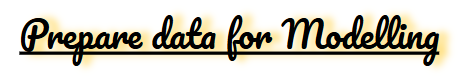

In [24]:
print("\n🤖 PREDICTIVE MODELING")
print("-" * 25)

# Prepare data for modeling
target = 'Purchase Amount (USD)'

categorical_features = ['Item Purchased', 'Payment Method', 'Season', 'Price_Category', 
                       'Rating_Category', 'Item_Category']
numerical_features = ['Review Rating', 'Month', 'Day_of_Week', 'Quarter', 
                     'Customer_Purchase_Frequency', 'Customer_CLV', 'Days_Since_Start']

# Encode categorical variables
le_dict = {}
df_model = df_features.copy()

for col in categorical_features:
    le = LabelEncoder()
    df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le

feature_cols = [col + '_encoded' for col in categorical_features] + numerical_features
X = df_model[feature_cols]
y = df_model[target]

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🤖 PREDICTIVE MODELING
-------------------------
Training set size: (2720, 13)
Test set size: (680, 13)


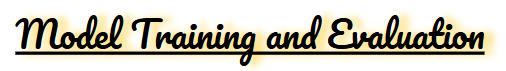

In [31]:
print("\n📊 MODEL TRAINING AND EVALUATION")
print("-" * 40)

# Updated models with tuning + Ridge & Lasso added
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=2,
        min_samples_split=5,
        min_samples_leaf=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=3,
        min_samples_split=5,
        min_samples_leaf=4,
        subsample=0.5,
        random_state=42
    ),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42, max_iter=10000)
}

model_results = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Scale for regression models that need it
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        
        y_train = y_train.fillna(y_train.median())
        y_test = y_test.fillna(y_test.median())

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Metrics
    train_pred = model.predict(X_train_scaled if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression'] else X_train)
    train_r2 = r2_score(y_train, train_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Cross-validation
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    model_results[name] = {
        'Train_R2_Score': train_r2,
        'Test_R2_Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'CV_Score_Mean': cv_scores.mean(),
        'CV_Score_Std': cv_scores.std(),
        'Model': model,
        'Predictions': y_pred
    }
    
    print(f"✅ {name} Results:")
    print(f"   Train R² Score: {train_r2:.4f}")
    print(f"   Test R² Score: {r2:.4f}")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAE: ${mae:.2f}")
    print(f"   CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")



📊 MODEL TRAINING AND EVALUATION
----------------------------------------

🔄 Training Random Forest...
✅ Random Forest Results:
   Train R² Score: 0.6369
   Test R² Score: 0.5313
   RMSE: $276.23
   MAE: $66.47
   CV Score: 0.5888 (±0.2179)

🔄 Training Gradient Boosting...
✅ Gradient Boosting Results:
   Train R² Score: 0.6853
   Test R² Score: 0.5200
   RMSE: $279.54
   MAE: $70.29
   CV Score: 0.5779 (±0.2176)

🔄 Training Linear Regression...
✅ Linear Regression Results:
   Train R² Score: 0.1909
   Test R² Score: 0.1731
   RMSE: $366.90
   MAE: $152.18
   CV Score: 0.1520 (±0.0774)

🔄 Training Ridge Regression...
✅ Ridge Regression Results:
   Train R² Score: 0.1909
   Test R² Score: 0.1732
   RMSE: $366.90
   MAE: $152.15
   CV Score: 0.1520 (±0.0774)

🔄 Training Lasso Regression...
✅ Lasso Regression Results:
   Train R² Score: 0.1909
   Test R² Score: 0.1732
   RMSE: $366.90
   MAE: $152.17
   CV Score: 0.1520 (±0.0774)


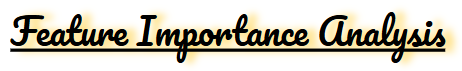 


📊 FEATURE IMPORTANCE
----------------------------------------

Top Features for Random Forest:
                        Feature  Importance
3        Price_Category_encoded    0.972060
11                 Customer_CLV    0.023696
6                 Review Rating    0.003773
7                         Month    0.000220
5         Item_Category_encoded    0.000101
12             Days_Since_Start    0.000056
10  Customer_Purchase_Frequency    0.000045
8                   Day_of_Week    0.000032
0        Item Purchased_encoded    0.000019
1        Payment Method_encoded    0.000000


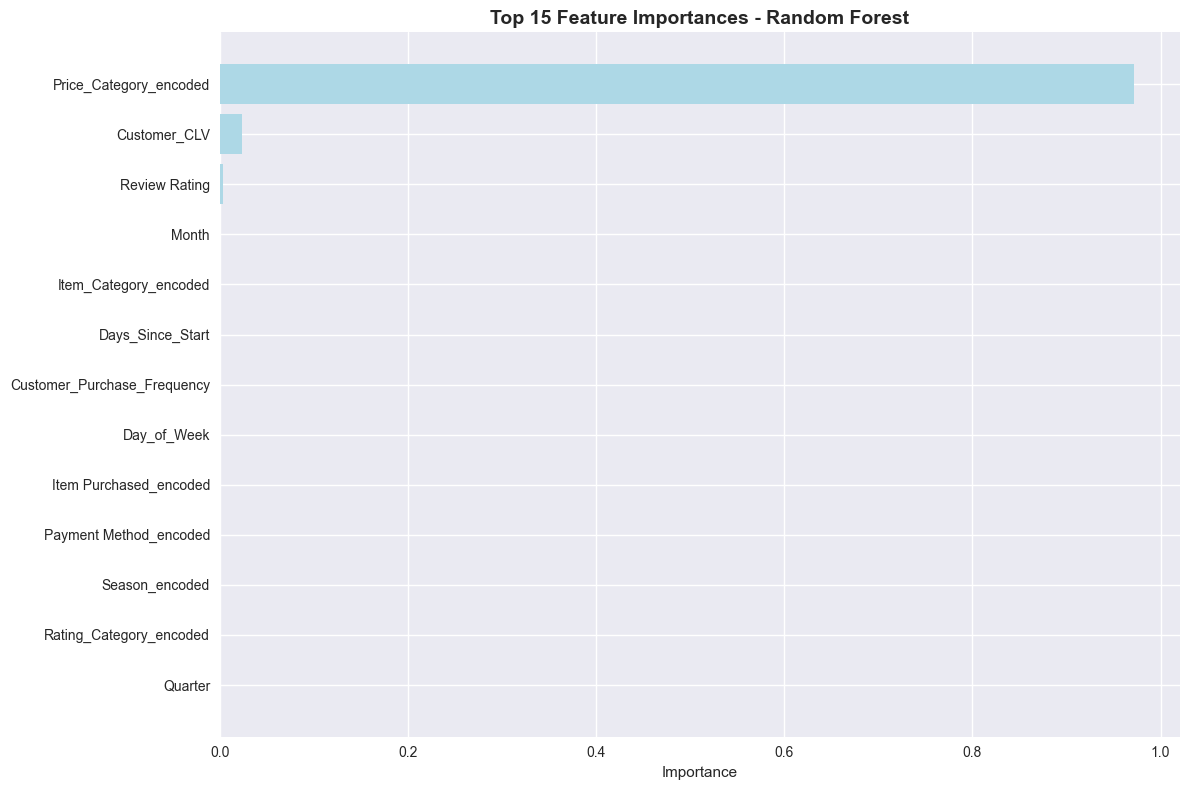


Top Features for Gradient Boosting:
                        Feature  Importance
3        Price_Category_encoded    0.842370
11                 Customer_CLV    0.068842
6                 Review Rating    0.042307
7                         Month    0.009601
0        Item Purchased_encoded    0.007843
10  Customer_Purchase_Frequency    0.007557
5         Item_Category_encoded    0.007266
12             Days_Since_Start    0.005843
8                   Day_of_Week    0.003949
2                Season_encoded    0.002221


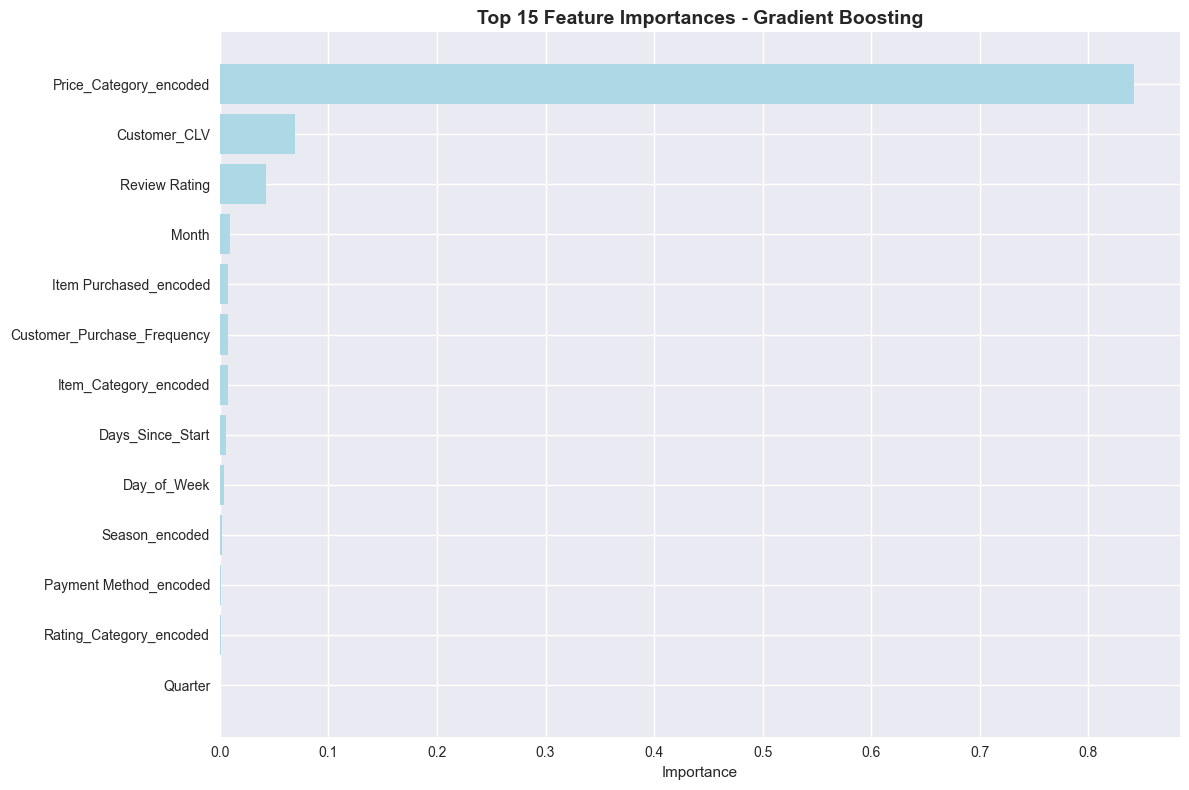

In [32]:
print("\n📊 FEATURE IMPORTANCE")
print("-" * 40)

for name in ['Random Forest', 'Gradient Boosting']:
    model = model_results[name]['Model']
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print(f"\nTop Features for {name}:")
        print(feature_importance.head(10))
        
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['Importance'], color='lightblue')
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.title(f'Top 15 Feature Importances - {name}', fontsize=14, fontweight='bold')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

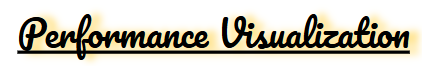


📈 MODEL PERFORMANCE VISUALIZATION
----------------------------------------

Performance plots for Random Forest


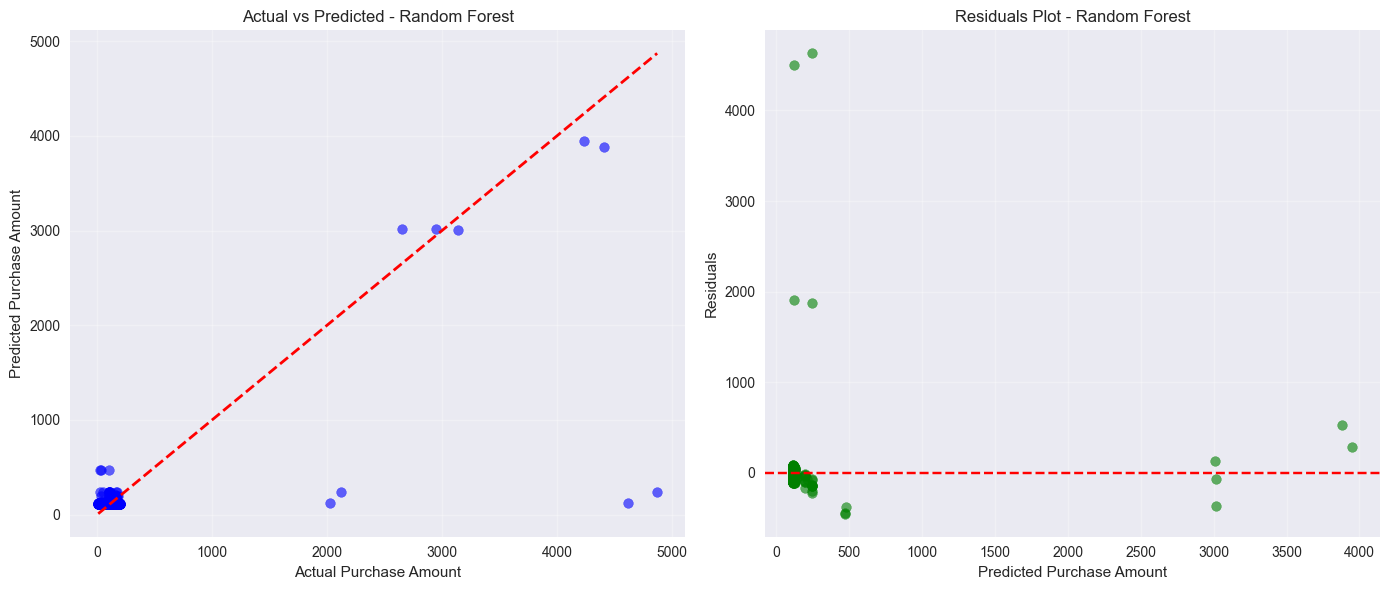


Performance plots for Gradient Boosting


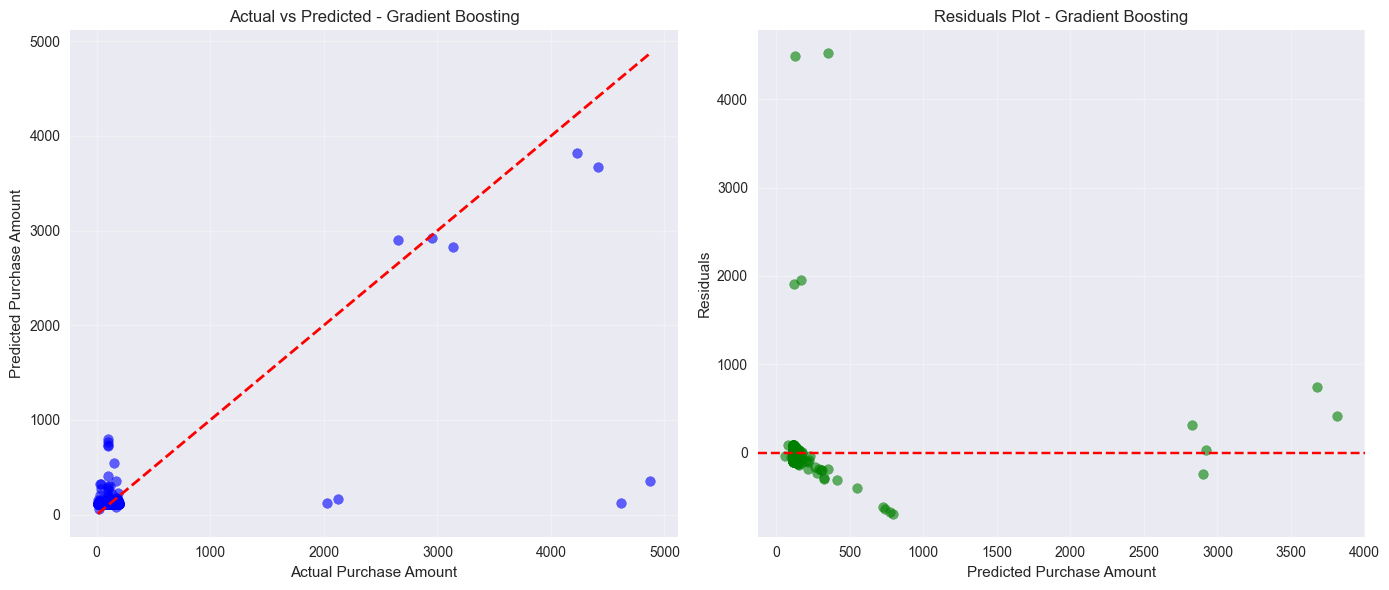


Performance plots for Linear Regression


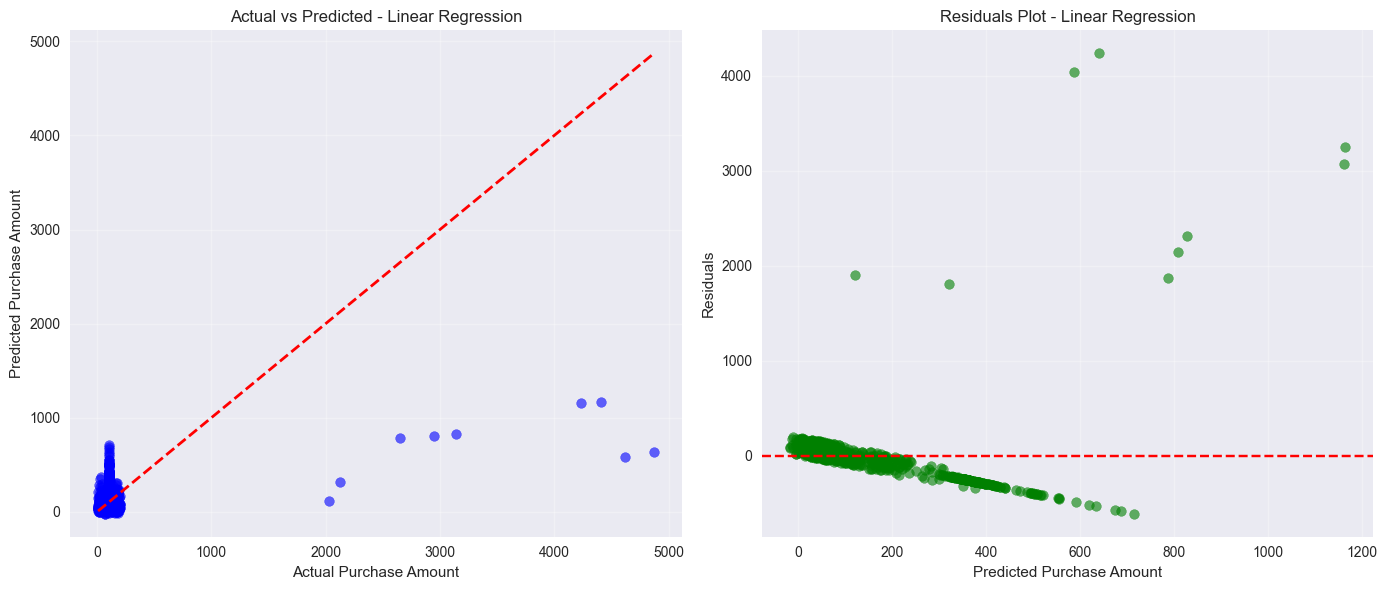


Performance plots for Ridge Regression


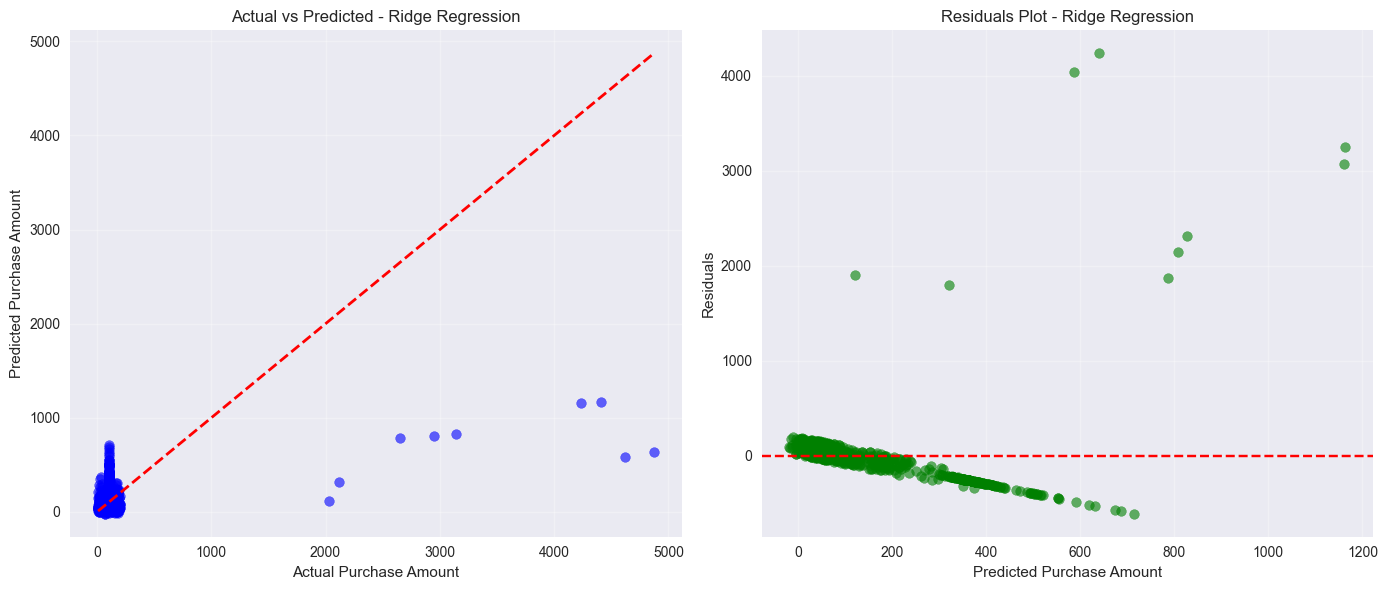


Performance plots for Lasso Regression


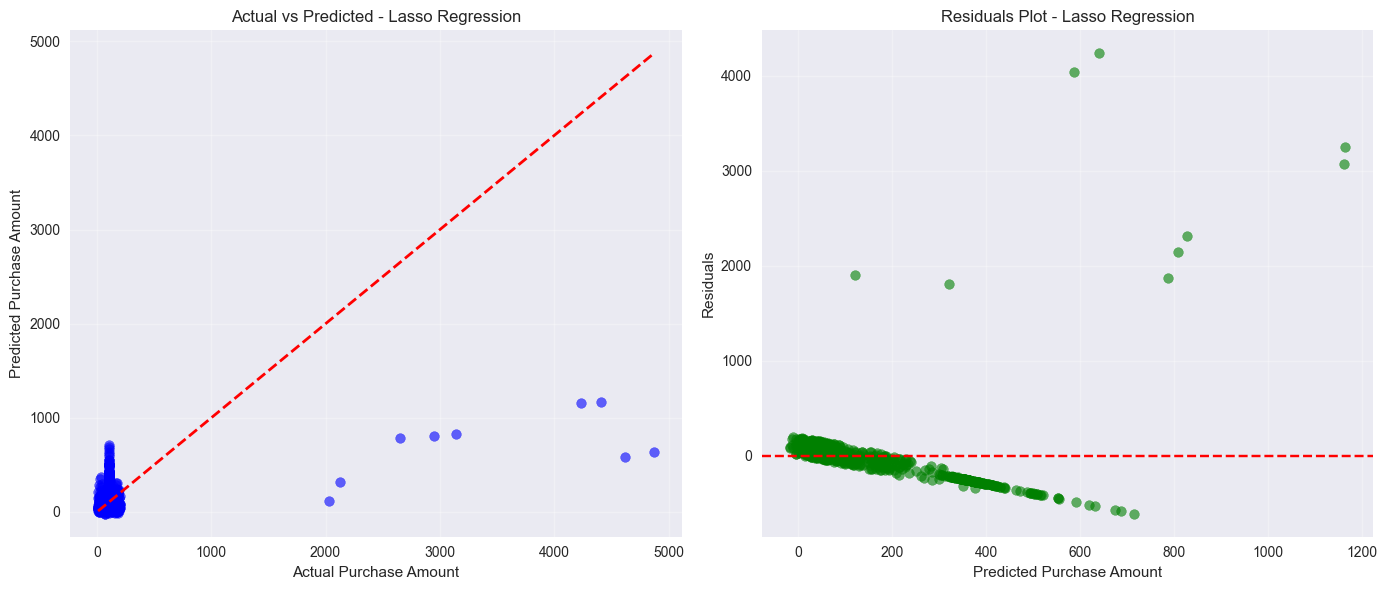

In [33]:
print("\n📈 MODEL PERFORMANCE VISUALIZATION")
print("-" * 40)

for name, results in model_results.items():
    y_pred = results['Predictions']
    model = results['Model']
    
    print(f"\nPerformance plots for {name}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Actual vs Predicted
    axes[0].scatter(y_test, y_pred, alpha=0.6, color='blue')
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0].set_xlabel('Actual Purchase Amount')
    axes[0].set_ylabel('Predicted Purchase Amount')
    axes[0].set_title(f'Actual vs Predicted - {name}')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals
    residuals = y_test - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, color='green')
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Predicted Purchase Amount')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'Residuals Plot - {name}')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()